## Data Loading and EDA

Loading Data and EDA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes

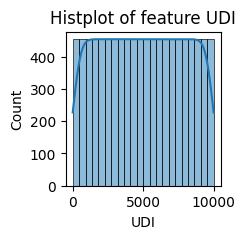

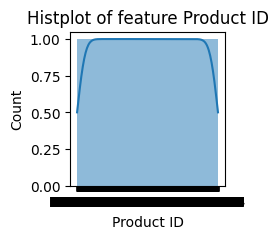

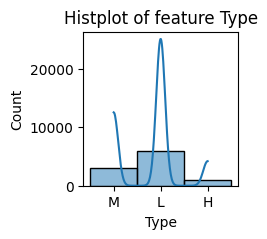

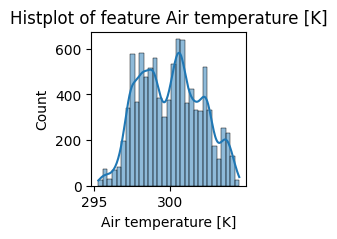

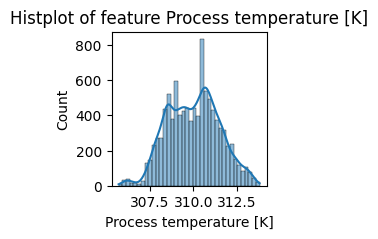

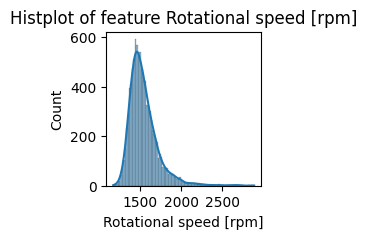

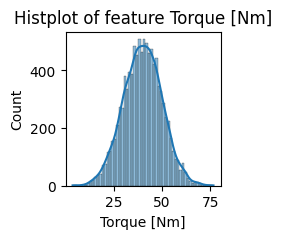

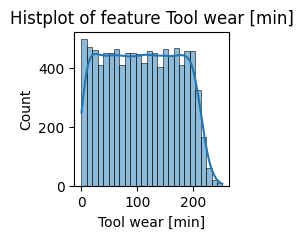

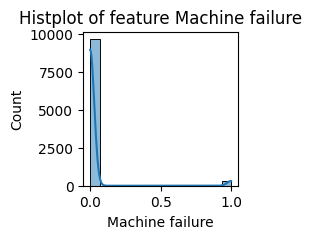

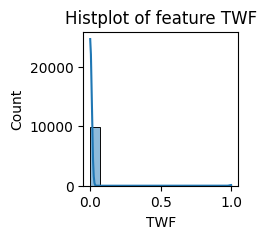

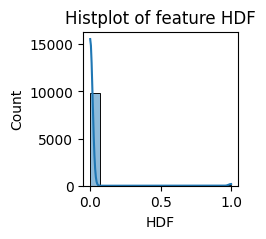

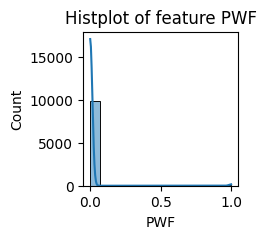

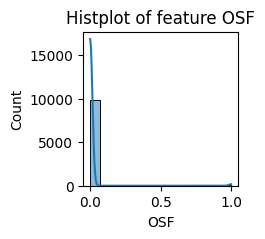

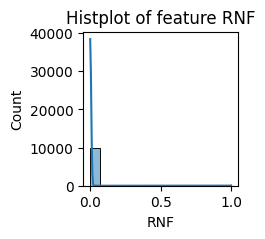



Bar Plot for all the values in the column 'Type'

One-Hot-Encoded the 'Type' Column
Removed the not-required Column

   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Machine failure  TWF  HDF  PWF  OSF  RNF  _H  \
0         42.8                0                0    0    0    0    0    0   0   
1         46.3                3                0    0    0    0    0    0   0   
2         49.4                5                0    0    0    0    0    0   0   
3         39.5                7                0    0    0    0    0    0   0   
4         40.0           

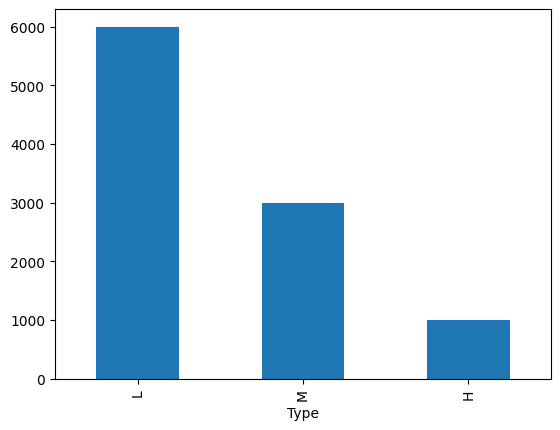

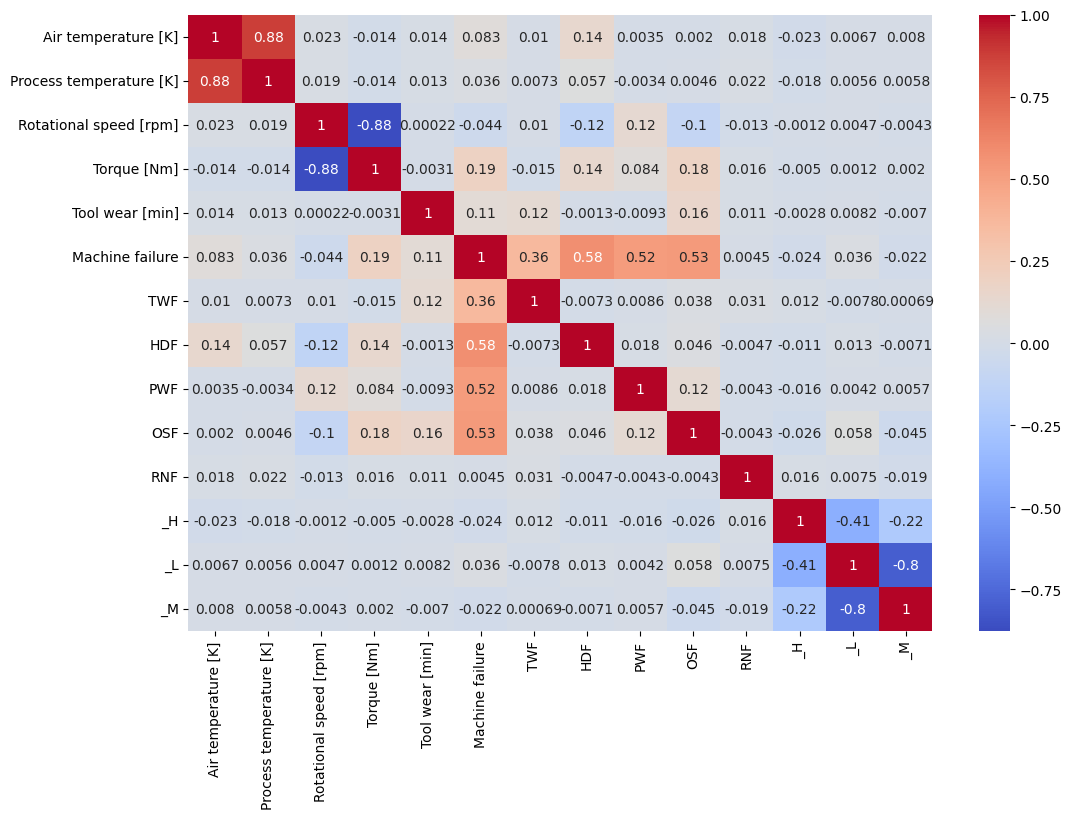

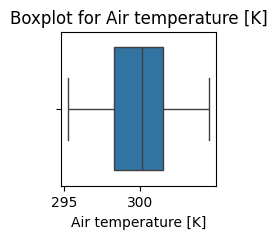

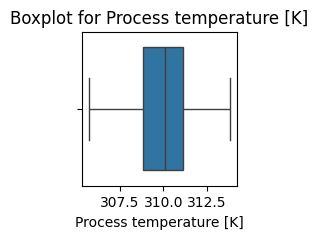

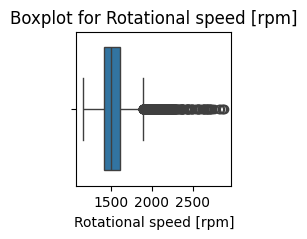

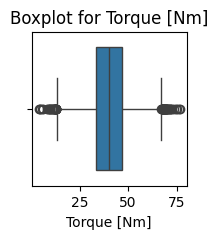

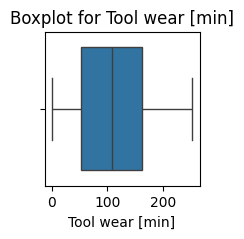

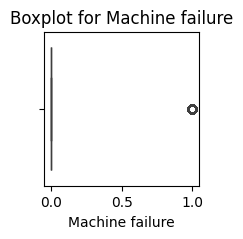

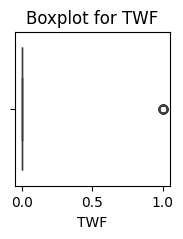

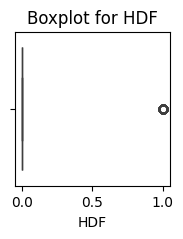

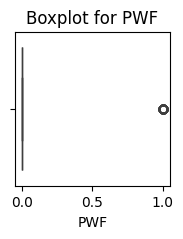

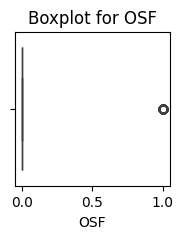

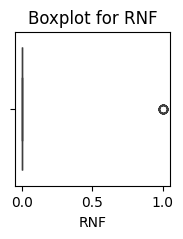

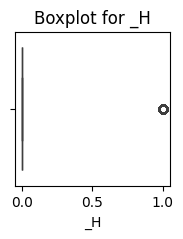

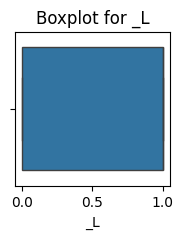

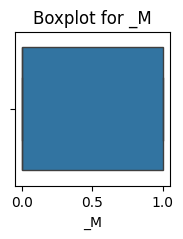

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Loading Data and EDA\n")

data = pd.read_csv('pred_maintenance.csv')
print(f"'Head'\n{data.head()}\n\n'Info'\n{data.info()}\n\n'Description'\n{data.describe()}\n\n'Null Values?'\n{data.isnull().sum()}\n\n'Unique Values'\n{data.nunique()}\n\n'Duplicates?'\n{data.duplicated().sum()}")


print("Histplot of all the Columns\n")
for columns in data.columns:
  plt.figure(figsize=(2, 2))
  sns.histplot(data[columns], kde=True)
  plt.title(f"Histplot of feature {columns}")
  plt.show()
  print("\n")


print("Bar Plot for all the values in the column 'Type'\n")
data['Type'].value_counts().plot(kind='bar')


print("One-Hot-Encoded the 'Type' Column\nRemoved the not-required Column\n")
data_encoded = pd.get_dummies(data, columns=['Type'], prefix="", dtype='int')
# print(f"{data_encoded.head()}")
new_data = data_encoded.copy()
new_data = new_data.drop(['Product ID', 'UDI'], axis=1)
print(f"{new_data.head()}")


print("Correlation Matrix")
plt.figure(figsize=(12, 8))
sns.heatmap(new_data.corr(), annot=True, cmap='coolwarm')


print("Looking for Outliers using Boxplot")
for column in new_data.columns:
    plt.figure(figsize=(2, 2))
    sns.boxplot(x=new_data[column])
    plt.title(f'Boxplot for {column}')
    plt.show()
    print("\n")

##CNN(1D) Model Training

In [ ]:
print("Model Selection and Training")

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
# from sklearn.model_selection import GridSearchCV
# import optuna
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier

tf.random.set_seed(42)


x, y = new_data.drop('Machine failure', axis=1), new_data['Machine failure']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

# rf_model = RandomForestClassifier()
# rf_model.fit(x_resampled, y_resampled)
# y_pred_rf = rf_model.predict(x_test)

x_resampled.columns = [col.replace("[", "_").replace("]", "_").replace("<", "_") for col in x_resampled.columns]
x_test.columns = [col.replace("[", "_").replace("]", "_").replace("<", "_") for col in x_test.columns]

# xgb_model = XGBClassifier()
# xgb_model.fit(x_resampled, y_resampled)
# y_pred_xgb = xgb_model.predict(x_test)


# X_train_lstm = np.reshape(x_resampled, (x_resampled.shape[0], 1, x_resampled.shape[1]))
# X_test_lstm = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))


print("Training 1D-CNN Model\n\n")
X_train_cnn = np.reshape(x_resampled, (x_resampled.shape[0], x_resampled.shape[1], 1))
X_test_cnn = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_resampled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Precision'])
cnn_model.fit(X_train_cnn, y_resampled, epochs=20, batch_size=32, validation_data=(X_test_cnn, y_test))

Model Selection and Training
Training 1D-CNN Model


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


483/483 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - Precision: 0.6572 - loss: 3.8382 - val_Precision: 0.0424 - val_loss: 1.7438
Epoch 2/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.8054 - loss: 0.5147 - val_Precision: 0.0450 - val_loss: 2.0585
Epoch 3/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Precision: 0.8456 - loss: 0.4157 - val_Precision: 0.0888 - val_loss: 0.8796
Epoch 4/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Precision: 0.8244 - loss: 0.6226 - val_Precision: 0.4000 - val_loss: 0.1118
Epoch 5/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Precision: 0.8703 - loss: 0.3935 - val_Precision: 0.7869 - val_loss: 0.0576
Epoch 6/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.8518 - loss: 0.4780 - val_Precision: 0.6341 - val_loss: 0.0689
Epoch 7/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.8780 - loss: 0.3600 - val_Precision: 0.3562 - val_loss: 0.1289
Epoch 8/20
483/483 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - Precision: 0.8813 - loss: 0.3509 - val_Precisio

# Testing the Model

In [ ]:
print("Model's Metrics and Result")
y_pred = cnn_model.predict(X_test_cnn)
y_pred = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"Accuracy => {accuracy}\nPrecision => {precision}\nRecall => {recall}\nF1-Score => {f1score}\nROC-AUC Score => {roc_auc}")

Model's Metrics and Result
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy => 0.989
Precision => 0.8095238095238095
Recall => 0.8360655737704918
F1-Score => 0.8225806451612904
ROC-AUC Score => 0.9149384083396037


# Saving the Trained Model

In [ ]:
print("saving the trained model\n")
cnn_model.save('cnn_model_final.h5')
print("Saved")

saving the trained model

Saved


In [ ]:
from google.colab import files
files.download('cnn_model_final.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing the Model with Custom Input

In [ ]:
from tensorflow.keras.models import load_model

# Load the model that you uploaded
model = load_model('cnn_model_final.h5')
print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 11, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │          20,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,867 (81.52 KB)

 Trainable params: 20,865 (81.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the model
model = load_model('cnn_model_final.h5')

# Custom input data (remove 'Machine failure' since it's what we are predicting)
custom_input = {
    "Air temperature _K_": 298.9,
    "Process temperature _K_": 309.1,
    "Rotational speed _rpm_": 2861,
    "Torque _Nm_": 2.6,
    "Tool wear _min_": 143,
    "TWF": 0,
    "HDF": 0,
    "PWF": 1,
    "OSF": 0,
    "RNF": 0,
    "_H": 0,
    "_L": 1,
    "_M": 0
}

# Prepare the custom input in the same order as the training data (without "Machine failure")
input_data = np.array([[
    custom_input["Air temperature _K_"],
    custom_input["Process temperature _K_"],
    custom_input["Rotational speed _rpm_"],
    custom_input["Torque _Nm_"],
    custom_input["Tool wear _min_"],
    custom_input["TWF"],
    custom_input["HDF"],
    custom_input["PWF"],
    custom_input["OSF"],
    custom_input["RNF"],
    custom_input["_H"],
    custom_input["_L"],
    custom_input["_M"]
]])

# Reshape to match the model input shape (1, 13, 1)
input_data_reshaped = input_data.reshape(input_data.shape[0], input_data.shape[1], 1)

# Make the prediction
prediction = model.predict(input_data_reshaped)

# Print the result
print("Prediction: ", prediction)

# Modify the threshold condition to show "Failure" if the prediction is >= 0.5
if prediction >= 0.5:
    print("Predicted: Failure")
else:
    print("Predicted: No Failure")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Prediction:  [[0.9999325]]
Predicted: Failure
